### First change the working directory to /scratch3/

In [93]:
import os
import time

In [111]:
import pickle

In [2]:
os.chdir('/scratch3/yufeil/oracle2/')

In [3]:
print(os.getcwd())

/scratch3/yufeil/oracle2


In [4]:
# All data files are stored in ./data/
os.listdir('data')

['heroes.csv',
 'hero_abilities.csv',
 'items.csv',
 'leagues.csv',
 'matches.csv',
 'sen_log.csv',
 'match_player_pairs.csv',
 'teams.csv',
 'obs_log.csv',
 'picks_bans.csv',
 'players.csv',
 'purchase_log.csv']

### Take a look at matches.csv

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [179]:
matches = pd.read_csv('data/matches.csv')
matches.head()

,match_id,match_seq_num,start_time,cluster_id,region_id,skill,radiant_win,radiant_heroes,dire_heroes,duration,...,barracks_status_dire,radiant_score,dire_score,is_parsed,times,radiant_gold_adv,radiant_xp_adv,league_id,radiant_team_id,dire_team_id
0,3383593335,2950481899,2017-08-17 17:04:12,122,2,3.0,f,"{50,104,51,14,70}","{8,7,9,22,86}",2511,...,63,19,39,f,NaN,NaN,NaN,0,NaN,NaN
1,3383580350,2950481900,2017-08-17 16:52:52,122,2,1.0,t,"{25,99,86,14,44}","{49,104,28,35,55}",3178,...,0,52,38,f,NaN,NaN,NaN,0,NaN,NaN
2,3383579821,2950481903,2017-08-17 16:52:13,123,2,1.0,f,"{104,106,8,25,54}","{12,13,71,49,18}",3050,...,63,36,55,f,NaN,NaN,NaN,0,NaN,NaN
3,3383568417,2950481904,2017-08-17 16:42:32,133,3,1.0,t,"{83,41,102,88,89}","{62,74,58,21,20}",3803,...,0,40,42,t,"{0,60,120,180,240,300,360,420,480,540,600,660,...","{0,73,175,277,372,561,378,40,-76,-572,-794,-10...","{0,58,-362,-309,187,91,620,213,243,-752,-516,-...",0,NaN,NaN
4,3383562936,2950481908,2017-08-17 16:37:28,251,15,NaN,t,"{5,98,93,113,62}","{48,7,39,23,61}",4090,...,0,59,79,t,"{0,60,120,180,240,300,360,420,480,540,600,660,...","{0,-34,-178,-322,86,-544,-580,-48,-70,190,-117...","{0,34,-204,-839,-322,-789,-1209,-660,-839,-806...",0,NaN,NaN


In [65]:
print(matches.dtypes)

match_id                     int64
match_seq_num                int64
start_time                  object
cluster_id                   int64
region_id                    int64
skill                      float64
radiant_win                 object
radiant_heroes              object
dire_heroes                 object
duration                     int64
lobby_type                   int64
game_mode                    int64
first_blood_time             int64
tower_status_radiant         int64
tower_status_dire            int64
barracks_status_radiant      int64
barracks_status_dire         int64
radiant_score                int64
dire_score                   int64
is_parsed                   object
times                       object
radiant_gold_adv            object
radiant_xp_adv              object
league_id                    int64
radiant_team_id            float64
dire_team_id               float64
dtype: object


In [19]:
matches.iloc[:,0].count()

332660

## <span style="color:coral;">Take a quick look at some basic info</span>

In [28]:
# Distribution of skills
skills_dist = matches.loc[:,'skill'].groupby(matches['skill']).agg({'matches':'count'})
print(skills_dist)

       matches
skill         
1.0     228904
2.0      29835
3.0      33027


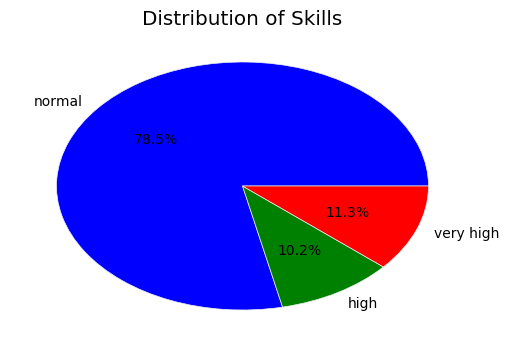

In [43]:
plt.pie(skills_dist['matches'], labels=['normal','high','very high'], autopct='%1.1f%%')
plt.title('Distribution of Skills')
plt.show()

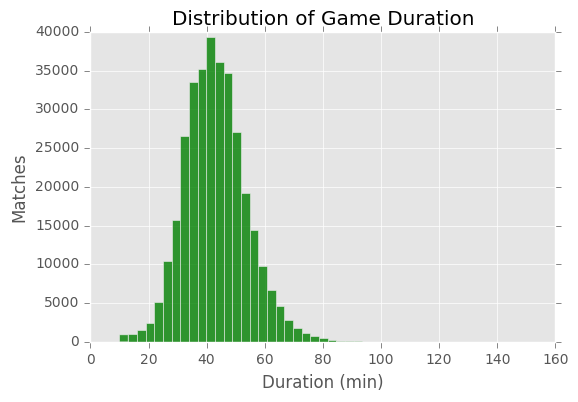

In [39]:
# Most of the matches are normal skilled.
# What about the match duration?
plt.hist(matches['duration']/60, bins=50, facecolor='g', alpha=0.8)
plt.xlabel('Duration (min)')
plt.ylabel('Matches')
plt.title('Distribution of Game Duration')
plt.show()

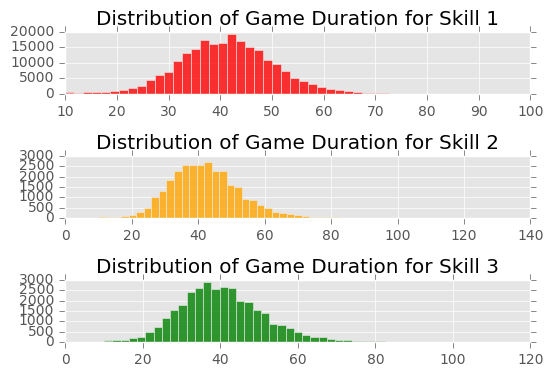

In [60]:
# The duration distributino looks like a skew normal distribution. 
# Is game duration also dependent on skills?
colors = ['r','orange','g']
fig, axs = plt.subplots(3,1)
fig.subplots_adjust(hspace=1)
for skill in range(1,4):
    ax = axs[skill-1]
    ax.hist(matches[matches['skill']==skill]['duration']/60, bins=50, facecolor=colors[skill-1], alpha=0.8)
    ax.set_title('Distribution of Game Duration for Skill {}'.format(skill))
plt.show()

In [ ]:
# It seems like high skill matches has the shortest duration.

## <span style="color:coral;">Analyze winning rate based on hero picked.</span>

In [63]:
# First we need to transform the matches data.
heroes_picked = matches[['radiant_heroes','dire_heroes','radiant_win']]
print(heroes_picked.head())
print(heroes_picked.shape)

      radiant_heroes        dire_heroes radiant_win
0  {50,104,51,14,70}      {8,7,9,22,86}           f
1   {25,99,86,14,44}  {49,104,28,35,55}           t
2  {104,106,8,25,54}   {12,13,71,49,18}           f
3  {83,41,102,88,89}   {62,74,58,21,20}           t
4   {5,98,93,113,62}    {48,7,39,23,61}           t
(332660, 3)


In [69]:
# The radiant_heroes and dire_heroes are list of selected heroes denoted by the corresponding hero ids.
# In order to build the feature space, we have several options:
# 1. xi = 1 if the i-th hero is on radiant, -1 if on the dire side, or 0 if not selected.
# 2. Double the feature size, for i from 1 to 114 (114 is the max hero id), xi = 0 or 1 denoting selected by radiant / not selected.
#    for i from 115 to 228, it denotes the dire heroes.
# I have tried the first way but the accuracy is not very high. So here we adopt the second method.

def extract_heroes(row):
    hero_series = {'hero_id_'+str(i):0 for i in range(1, 229)}
    
    heroes1,heroes2 = row['radiant_heroes'].lstrip('{').rstrip('}').split(','), row['dire_heroes'].lstrip('{').rstrip('}').split(',')
    
    for h in heroes1:
        hero_series['hero_id_'+str(h)] = 1
    for h in heroes2:
        hero_series['hero_id_'+str(int(h)+114)] = 1
    
    return pd.Series(hero_series)

columns = ['hero_id_'+str(i) for i in range(1, 229)] + ['radiant_win']
df = heroes_picked.apply(extract_heroes, axis=1)
print(df.head())

   hero_id_1  hero_id_10  hero_id_100  hero_id_101  hero_id_102  hero_id_103  \
0          0           0            0            0            0            0   
1          0           0            0            0            0            0   
2          0           0            0            0            0            0   
3          0           0            0            0            1            0   
4          0           0            0            0            0            0   

   hero_id_104  hero_id_105  hero_id_106  hero_id_107     ...      hero_id_90  \
0            1            0            0            0     ...               0   
1            0            0            0            0     ...               0   
2            1            0            1            0     ...               0   
3            0            0            0            0     ...               0   
4            0            0            0            0     ...               0   

   hero_id_91  hero_id_92  hero_

In [163]:
df['radiant_win'] = heroes_picked['radiant_win'].apply(lambda x: x == 't')
df.shape

(332660, 229)

In [178]:
df.head(2)

,hero_id_1,hero_id_10,hero_id_100,hero_id_101,hero_id_102,hero_id_103,hero_id_104,hero_id_105,hero_id_106,hero_id_107,...,hero_id_91,hero_id_92,hero_id_93,hero_id_94,hero_id_95,hero_id_96,hero_id_97,hero_id_98,hero_id_99,radiant_win
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,False
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,True


In [165]:
# Prepare the data for classification.
X = df.iloc[:,:-1]
y = df['radiant_win']

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### First let's simply run different classification models without tuning hyper-parameters.

#### 1. Logistic Regression

In [166]:
from sklearn.linear_model import LogisticRegression
lr_c = LogisticRegression()

start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

with open('lr_log.txt', 'a') as f:
    f.write("\nStart fitting... Time: {}".format(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))

lr_c.fit(X_train, y_train)
    
with open('lr_log.txt', 'a') as f:
    f.write("\nFinished fitting... Time: {}".format(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))

# Predicting the Test set results
y_pred = lr_c.predict(X_test)
y_score = lr_c.score(X_test, y_test)

with open('lr_log.txt', 'a') as f:
    f.write("\nAccuracy: {}. \nSaving model...".format(y_score))

from datetime import datetime
end_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
time_format = "%Y-%m-%d %H:%M:%S"
timeconsumed_lr = datetime.strptime(end_time, time_format) - datetime.strptime(start_time, time_format)
print("Time consumed: ", timeconsumed_lr)
print(y_score)

Time consumed:  0:00:01
0.590524860218


In [167]:
# Save the model
with open('lr_model.pkl', 'wb') as f:
    pickle.dump(lr_c, f)

#### 2. Naive Bayes

In [168]:
from sklearn.naive_bayes import GaussianNB
gaussian_nb = GaussianNB()

start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

with open('lr_log.txt', 'a') as f:
    f.write("\nStart fitting... Time: {}".format(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))

gaussian_nb.fit(X_train, y_train)
    
with open('lr_log.txt', 'a') as f:
    f.write("\nFinished fitting... Time: {}".format(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))

# Predicting the Test set results
y_pred = gaussian_nb.predict(X_test)
y_score = gaussian_nb.score(X_test, y_test)

with open('lr_log.txt', 'a') as f:
    f.write("\nAccuracy: {}. \nSaving model...".format(y_score))

from datetime import datetime
end_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
time_format = "%Y-%m-%d %H:%M:%S"
timeconsumed = datetime.strptime(end_time, time_format) - datetime.strptime(start_time, time_format)
print("Time consumed: ", timeconsumed)
print(y_score)

Time consumed:  0:00:01
0.574472434317


In [169]:
# Save the model
with open('nb_gaussian_model.pkl', 'wb') as f:
    pickle.dump(gaussian_nb, f)

#### 3. Adaboost

In [170]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()

start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

with open('lr_log.txt', 'a') as f:
    f.write("\nStart fitting... Time: {}".format(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))

ada.fit(X_train, y_train)
    
with open('lr_log.txt', 'a') as f:
    f.write("\nFinished fitting... Time: {}".format(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))

# Predicting the Test set results
y_pred = ada.predict(X_test)
y_score = ada.score(X_test, y_test)

with open('lr_log.txt', 'a') as f:
    f.write("\nAccuracy: {}. \nSaving model...".format(y_score))

from datetime import datetime
end_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
time_format = "%Y-%m-%d %H:%M:%S"
timeconsumed = datetime.strptime(end_time, time_format) - datetime.strptime(start_time, time_format)
print("Time consumed: ", timeconsumed)
print(y_score)

Time consumed:  0:00:43
0.574159802802


In [171]:
# Save the model
with open('ada_model.pkl', 'wb') as f:
    pickle.dump(ada, f)

#### 4. Random Forest

In [172]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 50)

start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

with open('lr_log.txt', 'a') as f:
    f.write("\nStart fitting... Time: {}".format(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))

rf.fit(X_train, y_train)
    
with open('lr_log.txt', 'a') as f:
    f.write("\nFinished fitting... Time: {}".format(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))

# Predicting the Test set results
y_pred = rf.predict(X_test)
y_score = rf.score(X_test, y_test)

with open('lr_log.txt', 'a') as f:
    f.write("\nAccuracy: {}. \nSaving model...".format(y_score))

from datetime import datetime
end_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
time_format = "%Y-%m-%d %H:%M:%S"
timeconsumed = datetime.strptime(end_time, time_format) - datetime.strptime(start_time, time_format)
print("Time consumed: ", timeconsumed)
print(y_score)

Time consumed:  0:00:59
0.566175674863


In [115]:
# Save the model
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

#### 5. SVM

In [107]:
from sklearn.svm import SVC
svc = SVC(kernel = 'rbf')

start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

with open('lr_log.txt', 'a') as f:
    f.write("\nStart fitting... Time: {}".format(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))

svc.fit(X_train, y_train)
    
with open('lr_log.txt', 'a') as f:
    f.write("\nFinished fitting... Time: {}".format(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))

# Predicting the Test set results
y_pred = svc.predict(X_test)
y_score = svc.score(X_test, y_test)

with open('lr_log.txt', 'a') as f:
    f.write("\nAccuracy: {}. \nSaving model...".format(y_score))

from datetime import datetime
end_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
time_format = "%Y-%m-%d %H:%M:%S"
timeconsumed = datetime.strptime(end_time, time_format) - datetime.strptime(start_time, time_format)
print("Time consumed: ", timeconsumed)
print(y_score)

Time consumed:  7:56:58
0.592112066374


In [116]:
# Save the model
with open('svc_model.pkl', 'wb') as f:
    pickle.dump(svc, f)

#### 5. KNN

#### KNN was run separately on Palmetto to save time.

### We can perform grid search to tune the hyper-parameters. Considering the computing time and accuracy, here we only select logistic regression to refine.

In [155]:
from sklearn.grid_search import GridSearchCV
classifier = LogisticRegression()
param_grid = {
            'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'penalty':['l1','l2']
            }
grid = GridSearchCV(classifier, param_grid, cv=10, scoring='accuracy')

In [156]:
grid.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [157]:
# Let's check the best parameters
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.591426681897
{'penalty': 'l1', 'C': 1}
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


### Seems like the highest accuracy we can get currently is less than 60%. In order to improve it, we can study the chemistry between heroes and how one hero can counter another opponent hero.

## <span style="color:olive;">Hero pairs and counters</span>.
###  Sometimes two heroes can have a much better performance when on the same side, just like team chemistry. So let's build a chemistry chart for all hero, based on the winning rate.
### Similarly, we can build a counter table to represent how one hero counters another when on different sides.

In [231]:
hero_pair_table = [[[0,0] for i in range(115)] for j in range(115)]  # Hero we don't use the first row/column.
hero_counter_table = [[[0,0] for i in range(115)] for j in range(115)]

In [232]:
heroes_picked['radiant_win'] = heroes_picked['radiant_win'].apply(lambda x: x=='t')
heroes_picked.head(3)

,radiant_heroes,dire_heroes,radiant_win
0,"{50,104,51,14,70}","{8,7,9,22,86}",False
1,"{25,99,86,14,44}","{49,104,28,35,55}",False
2,"{104,106,8,25,54}","{12,13,71,49,18}",False


In [233]:
from itertools import combinations
def get_hero_pair_counter_info(row):
    heroes1 = row['radiant_heroes'].lstrip('{').rstrip('}').split(',')
    heroes2 = row['dire_heroes'].lstrip('{').rstrip('}').split(',')
    rwin = row['radiant_win']
    
    heroes1 = list(map(int, heroes1))
    heroes2 = list(map(int, heroes2))
    
    # hero pairs
    for i, j in combinations(heroes1,2):
        hero_pair_table[i][j][0] += int(rwin)
        hero_pair_table[i][j][1] += 1
        
        hero_pair_table[j][i][0] += int(rwin)
        hero_pair_table[j][i][1] += 1
    for i, j in combinations(heroes2,2):
        hero_pair_table[i][j][0] += (rwin==False)
        hero_pair_table[i][j][1] += 1
        
        hero_pair_table[j][i][0] += (rwin==False)
        hero_pair_table[j][i][1] += 1
    
    # hero counters
    for i in heroes1:
        for j in heroes2:
            hero_counter_table[i][j][0] += int(rwin)
            hero_counter_table[i][j][1] += 1
            
            hero_counter_table[j][i][0] += (rwin==False)
            hero_counter_table[i][j][1] += 1
    
heroes_picked.apply(get_hero_pair_counter_info, axis=1)

0         None
1         None
2         None
3         None
4         None
5         None
6         None
7         None
8         None
9         None
10        None
11        None
12        None
13        None
14        None
15        None
16        None
17        None
18        None
19        None
20        None
21        None
22        None
23        None
24        None
25        None
26        None
27        None
28        None
29        None
          ... 
332630    None
332631    None
332632    None
332633    None
332634    None
332635    None
332636    None
332637    None
332638    None
332639    None
332640    None
332641    None
332642    None
332643    None
332644    None
332645    None
332646    None
332647    None
332648    None
332649    None
332650    None
332651    None
332652    None
332653    None
332654    None
332655    None
332656    None
332657    None
332658    None
332659    None
dtype: object

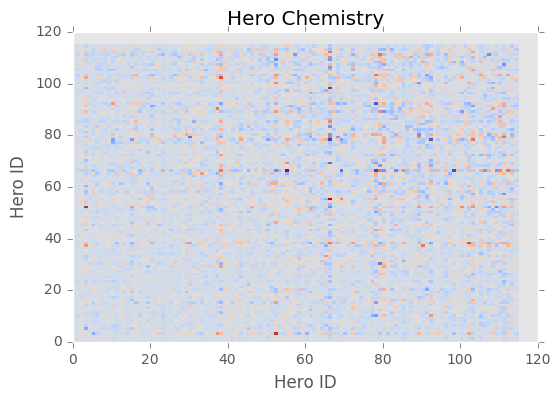

In [234]:
hero_pair_winrate = [[hero_pair_table[i][j][0]/hero_pair_table[i][j][1] if hero_pair_table[i][j][1]>0 else 0.5 for i in range(115)] for j in range(115)] 
hero_pair_winrate = np.array(hero_pair_winrate)
plt.pcolor(hero_pair_winrate,cmap=plt.cm.coolwarm)
plt.xlabel('Hero ID')
plt.ylabel('Hero ID')
plt.title('Hero Chemistry')
plt.show()

#### Do the same to hero counter

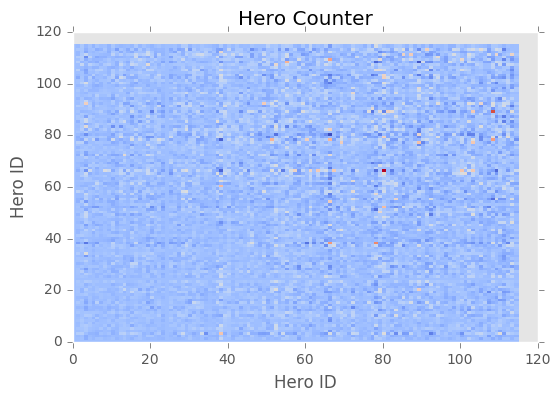

In [237]:
hero_counter_winrate = [[hero_counter_table[i][j][0]/hero_counter_table[i][j][1] if hero_counter_table[i][j][1]>0 else 0.5 for i in range(115)] for j in range(115)] 
hero_counter_winrate = np.array(hero_counter_winrate)
plt.pcolor(hero_counter_winrate,cmap=plt.cm.coolwarm)
plt.xlabel('Hero ID')
plt.ylabel('Hero ID')
plt.title('Hero Counter')
plt.show()

#### The graph is not that intuitive. Let's print out the top hero pairs and counters.

In [245]:
# Convert hero id to hero names:
import json
with open('misc_data/heroes.json') as heroes_json:
    raw_data = json.load(heroes_json)
    heroes = raw_data['heroes']
    
hero_id_to_name = {}
for hero in heroes:
    _id = hero['id']
    hero_id_to_name[_id] = hero['localized_name']

# In DOTA, there is no hero corresponding to id=24
hero_id_to_name[24] = 'Unkown'
# Hero_114 corresponds to the newly added hero Monkey King
hero_id_to_name[114] = 'Monkey King'

In [268]:
hero_pair_list = sorted([(hero_pair_winrate[i][j], hero_id_to_name[i], hero_id_to_name[j]) \
                         for i in range(1,114) for j in range(i+1,115) if hero_pair_table[i][j][1]>50\
                        ],reverse=True)

In [269]:
print("Best 5 hero pairs: \n", [a+'---'+b for rate, a, b in hero_pair_list[:5]])
print("Worst 5 hero pairs: \n", [a+'---'+b for rate, a, b in hero_pair_list[-5:]])

Best 5 hero pairs: 
 ['Bane---Leshrac', 'Beastmaster---Abaddon', 'Warlock---Keeper of the Light', 'Dark Seer---Doom', 'Leshrac---Tusk']
Worst 5 hero pairs: 
 ['Lone Druid---Naga Siren', 'Earth Spirit---Oracle', 'Leshrac---Terrorblade', 'Witch Doctor---Shadow Demon', 'Chen---Timbersaw']


In [270]:
hero_counter_list = sorted([(hero_counter_winrate[i][j], hero_id_to_name[i], hero_id_to_name[j]) \
                         for i in range(1,114) for j in range(i+1,115) if hero_counter_table[i][j][1]>50\
                        ],reverse=True)

In [271]:
print("Best 5 hero versus: \n", [a+' counters '+b for rate, a, b in hero_counter_list[:5]])

Best 5 hero versus: 
 ['Chen counters Lone Druid', 'Naga Siren counters Abyssal Underlord', 'Brewmaster counters Abyssal Underlord', 'Leshrac counters Lone Druid', 'Lycanthrope counters Naga Siren']


### The results make some sense, but we may need more data to get more precise result.

### Same calculation was performed on a 4 million dataset. Here is the result

In [360]:
hero_pair_winrate = np.load('/scratch3/yufeil/oracle/misc/hero_pair_winrate.npy')
hero_counter_winrate = np.load('/scratch3/yufeil/oracle/misc/hero_counter_winrate.npy')

In [362]:
hero_counter_winrate

array([[ 0.5       ,  0.5       ,  0.5       , ...,  0.5       ,
         0.5       ,  0.5       ],
       [ 0.5       ,  0.5       ,  0.59668859, ...,  0.46602972,
         0.37910162,  0.49528302],
       [ 0.5       ,  0.40540266,  0.5       , ...,  0.40355281,
         0.33571927,  0.41134598],
       ..., 
       [ 0.5       ,  0.53316375,  0.5981336 , ...,  0.5       ,
         0.43611111,  0.50499144],
       [ 0.5       ,  0.61889098,  0.66218545, ...,  0.5548926 ,
         0.5       ,  0.57105263],
       [ 0.5       ,  0.50472161,  0.59169921, ...,  0.49507458,
         0.42819149,  0.5       ]])

### With hero_pair and hero_counter information, we could get better classification result.  So we add two new features, chemistry and counter, by incorporating the results we just got.

In [387]:
def get_chemistry(row):
    heroes1 = row['radiant_heroes'].lstrip('{').rstrip('}').split(',')
    heroes2 = row['dire_heroes'].lstrip('{').rstrip('}').split(',')
    heroes1 = list(map(int, heroes1))
    heroes2 = list(map(int, heroes2))
    
    winrate_r, winrate_d = 1, 1
    
    for i, j in combinations(heroes1,2):
        winrate_r *= hero_pair_winrate[i][j]
    for i, j in combinations(heroes2,2):
        winrate_d *= hero_pair_winrate[i][j]
    
#     return winrate_r/winrate_d
    return winrate_r-winrate_d

def get_counter(row):
    heroes1 = row['radiant_heroes'].lstrip('{').rstrip('}').split(',')
    heroes2 = row['dire_heroes'].lstrip('{').rstrip('}').split(',')
    heroes1 = list(map(int, heroes1))
    heroes2 = list(map(int, heroes2))
    
#     counter = 1
    counter = 0
    
    for i in heroes1:
        for j in heroes2:
#             counter *= hero_counter_winrate[i][j]/0.5
            counter += hero_counter_winrate[i][j]
    
    return counter

df['chemistry'] = heroes_picked.apply(get_chemistry, axis=1)
df['counter'] = heroes_picked.apply(get_counter, axis=1)

In [364]:
df.head()

,hero_id_1,hero_id_10,hero_id_100,hero_id_101,hero_id_102,hero_id_103,hero_id_104,hero_id_105,hero_id_106,hero_id_107,...,hero_id_95,hero_id_96,hero_id_97,hero_id_98,hero_id_99,radiant_win,chemistry,counter,skill,tower_advantage
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,False,0.000340,12.241052,3.0,-7
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,True,-0.000370,12.799962,1.0,6
2,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,False,0.000079,12.555192,1.0,-7
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,True,0.001110,11.286713,1.0,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,True,0.000201,11.819558,NaN,6


### Let's standardization the newly added columns

In [388]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df['chemistry'] = sc.fit_transform(df['chemistry'].reshape(-1,1))

In [389]:
sc1 = StandardScaler()
df['counter'] = sc1.fit_transform(df['counter'].reshape(-1,1))

In [390]:
df[['chemistry','counter']].describe()

,chemistry,counter
count,3.326600e+05,3.326600e+05
mean,-1.899654e-18,-4.469709e-15
std,1.000002e+00,1.000002e+00
min,-6.554945e+00,-5.071727e+00
25%,-5.527444e-01,-6.796383e-01
50%,-1.029244e-03,1.345785e-03
75%,5.535619e-01,6.764086e-01
max,8.126442e+00,4.533247e+00


In [391]:
df[['chemistry','counter','radiant_win']].head(10)

,chemistry,counter,radiant_win
0,0.339638,-0.434750,False
1,-0.367530,0.483917,True
2,0.079395,0.081594,False
3,1.106188,-2.003374,True
4,0.200473,-1.127549,True
5,1.070658,-1.397332,True
6,-2.358842,1.688745,False
7,1.225336,-2.514110,True
8,-0.399405,0.516899,False
9,0.630126,-1.740670,False


### Now fit with logistic regression.

In [396]:
# Prepare the data for classification.
X_new = df.drop(['radiant_win','skill','tower_advantage'], axis=1)
y = df['radiant_win']

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25)

In [397]:
from sklearn.linear_model import LogisticRegression
lr_c_new = LogisticRegression()

start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

with open('lr_new_log.txt', 'a') as f:
    f.write("\nStart fitting... Time: {}".format(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))

lr_c_new.fit(X_train, y_train)
    
with open('lr_new_log.txt', 'a') as f:
    f.write("\nFinished fitting... Time: {}".format(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))

# Predicting the Test set results
y_score = lr_c_new.score(X_test, y_test)

with open('lr_new_log.txt', 'a') as f:
    f.write("\nAccuracy: {}. \nSaving model...".format(y_score))

from datetime import datetime
end_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
time_format = "%Y-%m-%d %H:%M:%S"
timeconsumed_lr = datetime.strptime(end_time, time_format) - datetime.strptime(start_time, time_format)
print("Time consumed: ", timeconsumed_lr)
print(y_score)

Time consumed:  0:00:03
0.602416882102


### Only a slight improvement we got. How about we only select a subset of the data where skill > 2? This is because at lower skilled matches, players' personal performance and skill are more important than the hero selected. 

In [398]:
df['skill'] = matches['skill']

In [399]:
df1 = df[df['skill']>=2]
df1.shape

(62862, 233)

In [400]:
# Prepare the data for classification.
X1 = df1.drop(['radiant_win','tower_advantage','skill'], axis=1)
y1 = df1['radiant_win']

from sklearn.cross_validation import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.25)

In [401]:
from sklearn.linear_model import LogisticRegression
lr1 = LogisticRegression()
lr1.fit(X1_train,y1_train)
y_score = lr1.score(X1_test, y1_test)
print(y_score)

0.600407228302


### The model might be optimized, if instead of simply assigning True/False as the dependent variable, we use tower/barracks status as the result of each match. This convert the problem from classification to regression, but we can convert it back to True/False based on the results fitted.
### The reason is that the tower/barracks status on both sides when a game ends can indicate how *stomping* the game is, which also depends on the hero selected. This method is analogous to predicting the result of a soccer game, where we use the final score rather than which team wins as the dependent variable.

#### Tower status coding and barracks status coding can be found:
#### https://dota2api.readthedocs.io/en/latest/responses.html#single-team-tower-status
#### Here we only use the tower status, and we convert it to the number of towers destroyed

In [328]:
matches['tower_status_radiant'].head()

0       0
1    1956
2       0
3    1572
4    1830
Name: tower_status_radiant, dtype: int64

In [333]:
tower_remaining_radiant = matches['tower_status_radiant'].apply(lambda x: bin(x).count("1"))
tower_remaining_dire = matches['tower_status_dire'].apply(lambda x: bin(x).count("1"))
df['tower_advantage'] = tower_remaining_radiant - tower_remaining_dire
df.head()

,hero_id_1,hero_id_10,hero_id_100,hero_id_101,hero_id_102,hero_id_103,hero_id_104,hero_id_105,hero_id_106,hero_id_107,...,hero_id_95,hero_id_96,hero_id_97,hero_id_98,hero_id_99,radiant_win,chemistry,counter,skill,tower_advantage
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,False,0.206462,0.146164,3.0,-7
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,True,-0.127198,-0.117269,1.0,6
2,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,False,-0.512321,-0.326627,1.0,-7
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,True,-0.596642,-0.416837,1.0,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,True,-0.240310,0.927178,NaN,6


## Now we perform regression on the data

### 1. Linear Regression

In [402]:
X = df.drop(['radiant_win','skill','tower_advantage'], axis=1)
y = df['tower_advantage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [403]:
from sklearn.linear_model import LinearRegression
lr_regressor = LinearRegression()
lr_regressor.fit(X_train, y_train)

y_predict = lr_regressor.predict(X_test)

In [404]:
radiant_win_predict = y_predict > 0
radiant_win_test = y_test > 0

accuracy = sum(radiant_win_predict == radiant_win_test) / len(radiant_win_test)
print(accuracy)

0.593518908195


### 2. SVM

In [ ]:
from sklearn.svm import SVR
svr_regressor = SVR(kernel = 'rbf')
svr_regressor.fit(X_train, y_train)

In [350]:
y_predict = svr_regressor.predict(X_test)
radiant_win_predict = y_predict > 0
radiant_win_test = y_test > 0

accuracy = sum(radiant_win_predict == radiant_win_test) / len(radiant_win_test)
print(accuracy)

0.586935609932


### 3. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

rf_regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
rf_regressor.fit(X_train, y_train)

y_predict = rf_regressor.predict(X_test)

radiant_win_predict = y_predict > 0
radiant_win_test = y_test > 0

accuracy = sum(radiant_win_predict == radiant_win_test) / len(radiant_win_test)
print(accuracy)

end_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
time_format = "%Y-%m-%d %H:%M:%S"
timeconsumed_lr = datetime.strptime(end_time, time_format) - datetime.strptime(start_time, time_format)
print("Time consumed: ", timeconsumed_lr)

## <span style="color:coral;">Analyze the hero importance.</span>

#### In order to analyze which heroes are the most important to determine the result, we can use random forest model. Other than that, it would be helpful if we fit the data using the feature space mentioned earlier: i from 1 to 114, xi = 0 if not selected, 1 if on radiant, and -1 if on dire. I have fit it that way and saved the model as 'random_forest_classifier.pkl'

In [108]:
from sklearn.externals import joblib
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

In [123]:
classifier = joblib.load('../oracle/random_forest_classifier.pkl')

In [131]:
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
             axis=0)

In [137]:
indices = np.argsort(importances)[::-1]

In [138]:
print("Feature ranking:")

for f in range(150):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 103 (0.020110)
2. feature 34 (0.019514)
3. feature 92 (0.019186)
4. feature 7 (0.018051)
5. feature 10 (0.018027)
6. feature 3 (0.017062)
7. feature 0 (0.015480)
8. feature 8 (0.014990)
9. feature 62 (0.014775)
10. feature 5 (0.014399)
11. feature 53 (0.014084)
12. feature 105 (0.013489)
13. feature 73 (0.013357)
14. feature 27 (0.013290)
15. feature 17 (0.013046)
16. feature 25 (0.012887)
17. feature 61 (0.012691)
18. feature 16 (0.012155)
19. feature 94 (0.012133)
20. feature 83 (0.012030)
21. feature 87 (0.012027)
22. feature 69 (0.011953)
23. feature 97 (0.011900)
24. feature 6 (0.011815)
25. feature 15 (0.011746)
26. feature 40 (0.011729)
27. feature 85 (0.011561)
28. feature 47 (0.011514)
29. feature 46 (0.011454)
30. feature 74 (0.011394)
31. feature 33 (0.011243)
32. feature 96 (0.011231)
33. feature 98 (0.011212)
34. feature 70 (0.011144)
35. feature 72 (0.010508)
36. feature 75 (0.010429)
37. feature 113 (0.010317)
38. feature 19 (0.010134)
39. fea

In [139]:
heroes_importance = {i+1:imp for i, imp in enumerate(importances) if imp != 0}

In [140]:
# Let's doublce check how many heroes we have.
print(len(heroes_importance))

114


### Let's convert the hero id to the hero's name. This could be done with heroes.json file, where the information of all heroes are stored.

In [141]:
import json

In [144]:
with open('misc_data/heroes.json') as heroes_json:
    raw_data = json.load(heroes_json)
    heroes = raw_data['heroes']

In [145]:
results = {}
for hero in heroes:
    _id = hero['id']
    imp = heroes_importance[_id]
    results[hero['localized_name']] = imp

In [146]:
results_list = [(val, key) for key, val in results.items()]
results_list.sort(reverse=True)

In [147]:
print("{}Importance\n".format("Hero".ljust(20)))
for r1, r2 in results_list:
    print("{}{}".format(r2.ljust(20),r1))

Hero                Importance

Legion Commander    0.020109889231494014
Sniper              0.019514091337410184
Slark               0.019185989136750962
Juggernaut          0.018051020813582695
Shadow Fiend        0.01802721672967949
Bloodseeker         0.017061880680004318
Anti-Mage           0.015479995434883136
Mirana              0.014990166831142519
Weaver              0.014775111117547132
Drow Ranger         0.014398723847283221
Lifestealer         0.014084149456104367
Ember Spirit        0.01348913950604486
Invoker             0.013357240910903682
Slardar             0.013289711394733944
Sven                0.013045777458624414
Lion                0.012886869344178691
Bounty Hunter       0.012691336284039767
Storm Spirit        0.012154712766614523
Troll Warlord       0.01213250269184795
Ogre Magi           0.01202957623687573
Nyx Assassin        0.012027113276930176
Ursa                0.01195251355079175
Timbersaw           0.01190012826297458
Earthshaker         0.011815423

### It can be seen that most *carry* heroes are crucial to determine the result of the game, while most *support* heroes are not that important. This is consistent with my game experience.

#### Let's plot the Top 10 most important and most insignificant heroes.

In [148]:
importances, names = zip(*results_list[:10]+results_list[-10:])
print(names)
print(importances)

('Legion Commander', 'Sniper', 'Slark', 'Juggernaut', 'Shadow Fiend', 'Bloodseeker', 'Anti-Mage', 'Mirana', 'Weaver', 'Drow Ranger', 'Naga Siren', 'Leshrac', 'Brewmaster', 'Oracle', 'Beastmaster', 'Broodmother', 'Wisp', 'Arc Warden', 'Visage', 'Chen')
(0.020109889231494014, 0.019514091337410184, 0.019185989136750962, 0.018051020813582695, 0.018027216729679489, 0.017061880680004318, 0.015479995434883136, 0.014990166831142519, 0.014775111117547132, 0.014398723847283221, 0.0041999026864267992, 0.0039656704122808268, 0.0036687213682671249, 0.0034451417112129406, 0.0033766264476415286, 0.0031635531382143227, 0.0028735113692605766, 0.002842442471738827, 0.0026999749038472847, 0.0026108021427491256)


In [149]:
len(names)

20

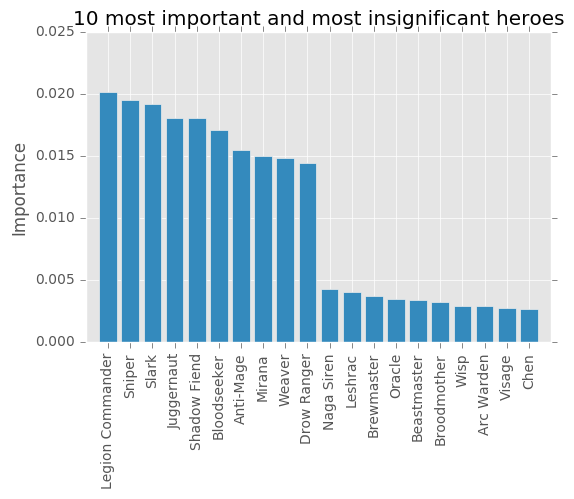

In [150]:
plt.bar(range(20), importances, width=0.8, align='center')
plt.title("10 most important and most insignificant heroes")
plt.ylabel("Importance")
plt.xticks(range(20), names, rotation='vertical')
plt.xlim([-1,20])
plt.show()

### Note that the most important doesn't mean the highest win rate. Still, we can see that there is a considerable difference between *carry* and *support* heroes regarding the importance.

## <span style="color:coral;">Hero Recommendation System and Clustering</span>

### Hero Recommendation System was built separately using Spark on Hortonworks. Other than that, we can cluster heroes based on their similarities.

## <span style="color:coral;">Other Analysis</span>

### We can plot the postion of wards placed at different time in a game. I did it in Tableau and uploaded to S3.

<img src="https://s3.us-east-2.amazonaws.com/dotaoracle-public/obs_map.png">

### It can be seen that at early games, most observer wards are placed near the *river* (from top-left to bottom-right). But wards placed at later time will be mostly around the buildings or neutral camps.